# Fairness, Accountability, Transparency and Ethics Course (FATE)

## Universitat Pompeu Fabra (UPF)
### Academic Year 2025-2026
### Author: Ashwin Singh (ashwin.singh01@estudiant.upf.edu)

# Installs & Imports

In [ ]:
!pip install aif360
!pip install 'aif360[Reductions]'
!pip install 'aif360[inFairness]'

In [ ]:
# change your python version to fit the paths

!wget https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data -P /usr/local/lib/python3.11/dist-packages/aif360/data/raw/german/
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.doc -P /usr/local/lib/python3.11/dist-packages/aif360/data/raw/german/

--2025-02-20 21:55:54--  https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘/usr/local/lib/python3.11/dist-packages/aif360/data/raw/german/german.data.2’

german.data.2           [ <=>                ]  77.92K  --.-KB/s    in 0.03s   

2025-02-20 21:55:57 (2.65 MB/s) - ‘/usr/local/lib/python3.11/dist-packages/aif360/data/raw/german/german.data.2’ saved [79793]

--2025-02-20 21:55:57--  https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.doc
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘/usr/local/lib/

In [ ]:
# Pre-Processing Imports
from aif360.algorithms.preprocessing.optim_preproc import OptimPreproc
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_german
from aif360.algorithms.preprocessing.optim_preproc_helpers.distortion_functions import get_distortion_german
from aif360.algorithms.preprocessing.optim_preproc_helpers.opt_tools import OptTools
from aif360.algorithms.preprocessing.reweighing import Reweighing

# In-Processing Imports
from aif360.algorithms.inprocessing.exponentiated_gradient_reduction import ExponentiatedGradientReduction

# Post-Processing Imports
from aif360.algorithms.postprocessing.calibrated_eq_odds_postprocessing import CalibratedEqOddsPostprocessing

# Other Imports
from aif360.datasets import GermanDataset, StructuredDataset
from aif360.metrics import ClassificationMetric

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import *

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import warnings

In [ ]:
warnings.filterwarnings(action="ignore")
sns.set_theme(style='whitegrid')

# Data

A detailed description for all attributes in data is available [here](https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data), under *Additional Variable Information*.

In [ ]:
data = GermanDataset()
data.labels %= 2 # 0 if credit score is bad, else 1

dataset, info = data.convert_to_dataframe()
dataset.head()

,month,credit_amount,investment_as_income_percentage,residence_since,age,number_of_credits,people_liable_for,sex,status=A11,status=A12,...,housing=A153,skill_level=A171,skill_level=A172,skill_level=A173,skill_level=A174,telephone=A191,telephone=A192,foreign_worker=A201,foreign_worker=A202,credit
0,6.0,1169.0,4.0,4.0,1.0,2.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
1,48.0,5951.0,2.0,2.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
2,12.0,2096.0,2.0,3.0,1.0,1.0,2.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
3,42.0,7882.0,2.0,4.0,1.0,1.0,2.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
4,24.0,4870.0,3.0,4.0,1.0,2.0,2.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


# Underlying Biases

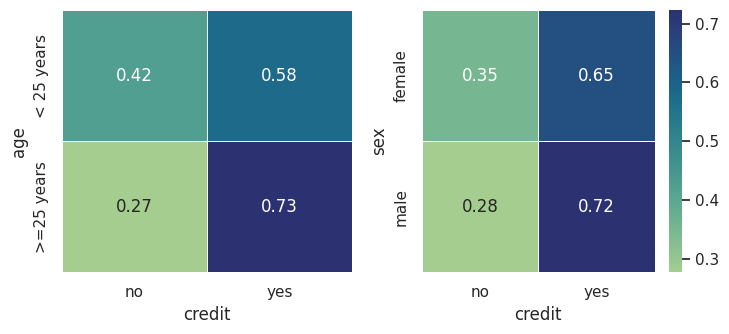

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(3.5)
fig.set_figwidth(7.5)

_ = dataset.copy()
_.age = _.age.map(lambda age: {0:"< 25 years",1:">=25 years"}[age])
_.sex = _.sex.map(lambda sex: {0:"female",1:"male"}[sex])
_.credit = _.credit.map(lambda credit: {1:"yes", 0:"no"}[credit])

sns.heatmap(
    data = pd.crosstab(
        _.age,
        _.credit,
        normalize="index"
    ),
    annot = True,
    fmt = ".2f",
    ax = ax1,
    linewidth=.5,
    cmap = "crest",
    cbar=False
)

sns.heatmap(
    data = pd.crosstab(
        _.sex,
        _.credit,
        normalize="index"
    ),
    annot=True,
    fmt=".2f",
    ax = ax2,
    linewidth=.5,
    cmap = "crest"
)

plt.tight_layout()
plt.show()

In [ ]:
_.groupby(['age','sex']).credit.value_counts(normalize=True)

age         sex     credit
< 25 years  female  yes       0.552381
                    no        0.447619
            male    yes       0.611765
                    no        0.388235
>=25 years  female  yes       0.697561
                    no        0.302439
            male    yes       0.738843
                    no        0.261157
Name: proportion, dtype: float64

# Modeling Loan Approval

## Train-Test Split

The data is split into train set and test set in an 80-20 ratio, and shuffled for randomization.

In [ ]:
train, test = data.split([0.8], shuffle=True, seed=42)

base_train, _ = train.convert_to_dataframe()
base_test, _ = test.convert_to_dataframe()

## Preprocessing

In [ ]:
numerical = ["month", "credit_amount", "investment_as_income_percentage",
             "residence_since", "number_of_credits", "people_liable_for"]

scaler = StandardScaler()

base_train[numerical] = scaler.fit_transform(base_train[numerical])
base_test[numerical] = scaler.transform(base_test[numerical])

## Model Training and Evaluation

In [ ]:
def evaluate(model,X_test,y_test):

    y_pred = model.predict(X_test)

    acc = accuracy_score(
        y_true = y_test,
        y_pred = y_pred
    )

    ConfusionMatrixDisplay.from_predictions(
        y_true = y_test,
        y_pred = y_pred,
        cmap = "crest",
        colorbar=False
    )

    plt.title(f"Accuracy: {round(acc,2)}")
    plt.grid(False)
    plt.show()

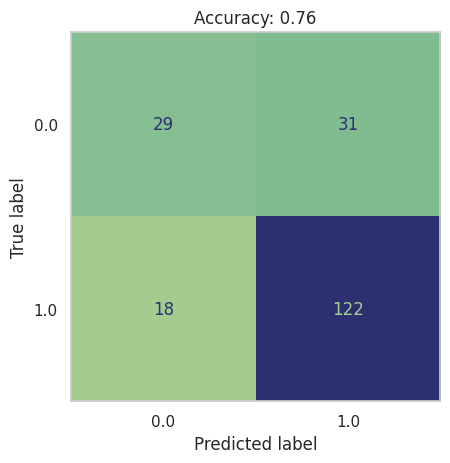

In [ ]:
X_train, y_train = base_train[info["feature_names"]], base_train["credit"]
X_test, y_test = base_test[info["feature_names"]], base_test["credit"]

base_model = LogisticRegression()
base_model = base_model.fit(X_train, y_train)

evaluate(base_model,X_test,y_test)

# ROC Curves

Each point in the ROC curve corresponds to a particular classification threshold $\theta$ for a model f, such that if $f(x) \geq \theta \implies \widehat{y} = 1$, and $0$ otherwise. By plotting false-positive and true-positive rates for each $\theta$ we can study the trade-offs for different thresholds $\theta$

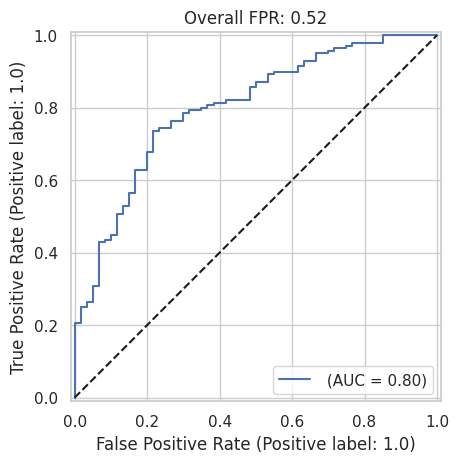

In [ ]:
def plot_roc(model,X,y,ax=None,label=""):

    yp = model.predict(X)
    tn, fp, fn, tp = confusion_matrix(y, yp).ravel()
    fpr = (fp / (tn + fp))

    RocCurveDisplay.from_estimator(
        model,
        X,
        y,
        ax=ax,
        plot_chance_level=True,
        chance_level_kw = {"label":None},
        name=""
    )

    if ax is not None:
        ax.set_title(
            f"{label} | FPR: {round(fpr,2)}"
        )
    else:
        plt.title(
            f"Overall FPR: {round(fpr,2)}"
        )

plot_roc(base_model,X_test,y_test)
plt.show()

## Groupwise

Loan Approval is an **assistive** intervention - therefore it is interesting to see for which groups, the model affords higher **false-positive rates** i.e., loan approval rates for individuals who will not pay it back. What do they indicate?

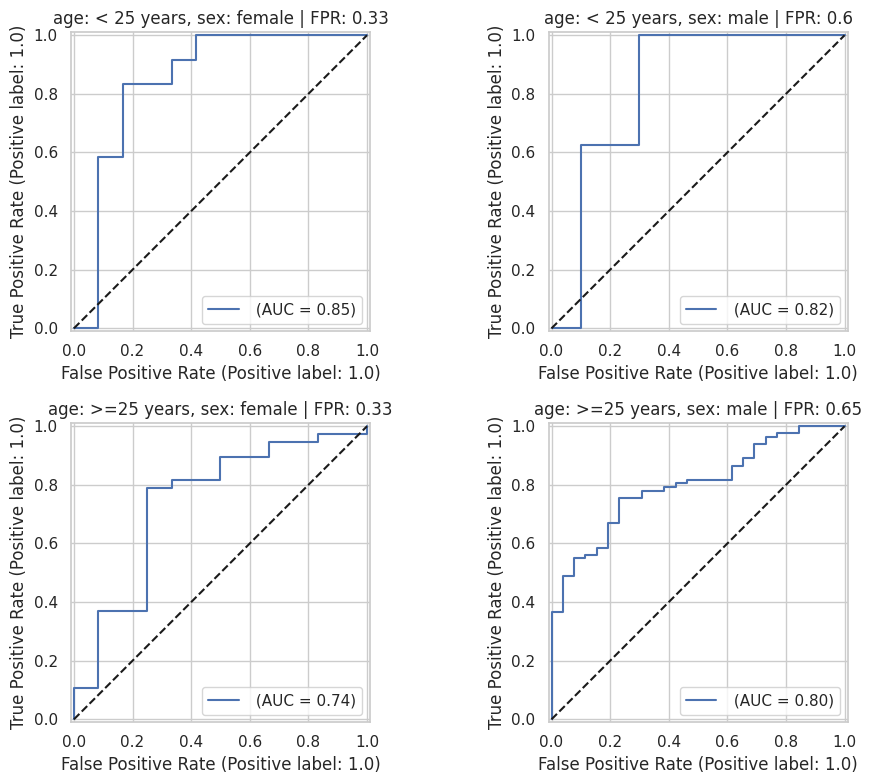

In [ ]:
def plot_roc_by_group(model,test,info):

    fig, axes = plt.subplots(2, 2)

    fig.set_figheight(8)
    fig.set_figwidth(10)

    grouped = test.groupby(["age","sex"])
    groups = grouped.groups.keys()

    for group in groups:
        _ = grouped.get_group(group)
        X, y = _[info["feature_names"]], _["credit"]
        ax = axes[int(group[0])][int(group[1])]
        label = f"""age: {"< 25 years" if not group[0] else ">=25 years"}, sex: {"female" if not group[1] else "male"}"""
        plot_roc(model,X,y,label=label,ax=ax)

    plt.tight_layout()
    plt.show()

plot_roc_by_group(base_model, base_test, info)

# Error Detection Curve

Similar to ROC, each point in the error-detection curve corresponds to a particular classification threshold $\theta$ for a model f, such that if $f(x) \geq \theta \implies \widehat{y} = 1$, and $0$ otherwise. By plotting false-positive and false-negative rates for each $\theta$ we can study the trade-offs for different thresholds $\theta$.

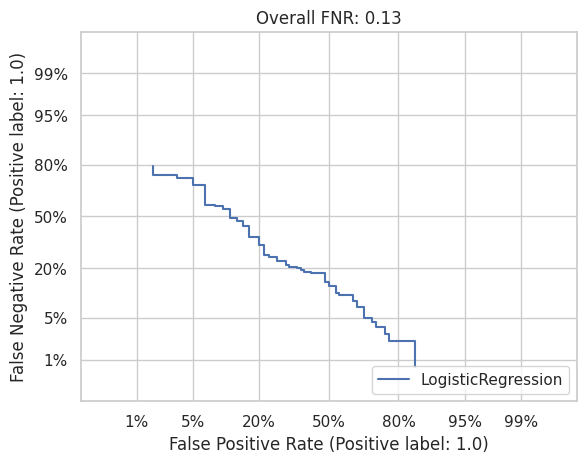

In [ ]:
def plot_edc(model,X,y,ax=None,label=""):

    yp = model.predict(X)
    tn, fp, fn, tp = confusion_matrix(y, yp).ravel()
    fnr = (fn / (tp + fn))

    DetCurveDisplay.from_estimator(
        model,
        X,
        y,
        ax=ax
    )

    if ax is not None:
        ax.set_title(
            f"{label} | FNR: {round(fnr,2)}"
        )
    else:
        plt.title(
            f"Overall FNR: {round(fnr,2)}"
        )


plot_edc(base_model,X_test,y_test)
plt.show()

## Groupwise

This is more relevant for **assistive** interventions, as not approving loans for individuals who will pay it back **(false-negatives)** is a worse outcome than the opposite. What do different **(false-negative rates)** by groups indicate?

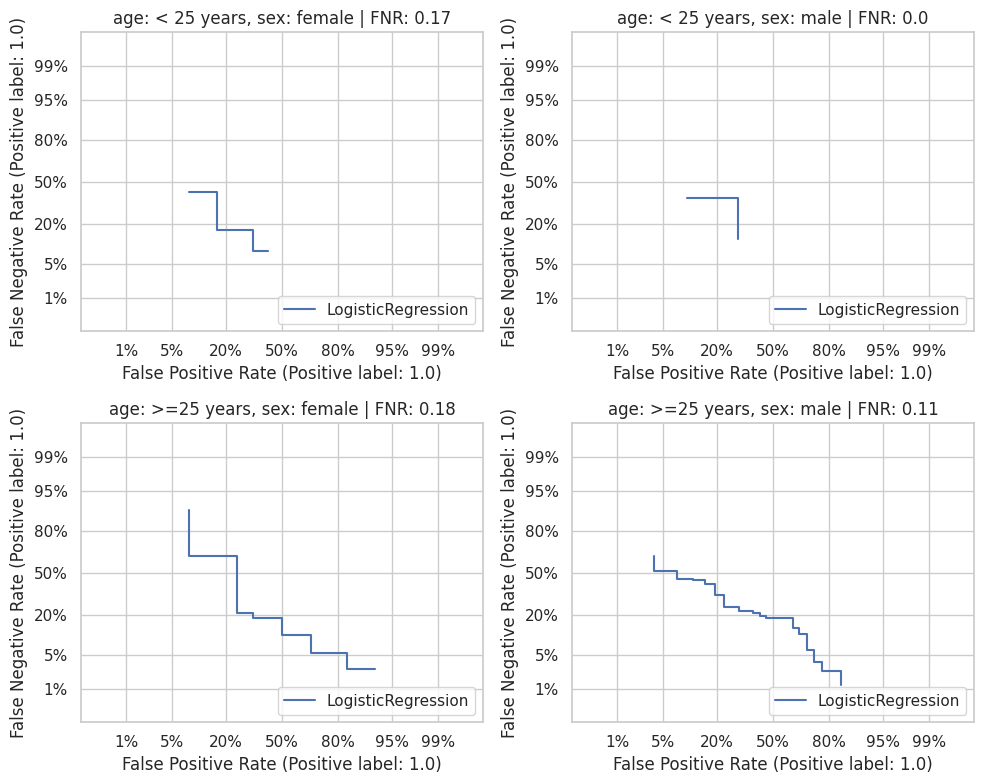

In [ ]:
def plot_edc_by_group(model,test,info):

    fig, axes = plt.subplots(2, 2)
    fig.set_figheight(8)
    fig.set_figwidth(10)

    grouped = test.groupby(["age","sex"])
    groups = grouped.groups.keys()

    for group in groups:
        _ = grouped.get_group(group)
        X, y = _[info["feature_names"]], _["credit"]
        ax = axes[int(group[0])][int(group[1])]
        label = f"""age: {"< 25 years" if not group[0] else ">=25 years"}, sex: {"female" if not group[1] else "male"}"""
        plot_edc(model,X,y,ax=ax,label=label)

    plt.tight_layout()
    plt.show()

plot_edc_by_group(base_model,base_test,info)

# Fairness Metrics

1. **False Negative Rate Ratio** $= \frac{FNR_{A=\text{unprivileged}}}{FNR_{A=\text{privileged}}}$

2. **False Negative Rate Difference** $ = FNR_{A=\text{unprivileged}} - FNR_{A=\text{privileged}}$

3. **Disparate Impact** $= \frac{P(\;\widehat{Y}=1\;|\;A=\text{unprivileged}\;)}{P(\;\widehat{Y}=1\;|\;A=\text{privileged}\;)}$


More generally, metrics **1, 2** are variants of error rate ratio, and error rate difference.

In [ ]:
def fairness_metrics(model,test,info):

    protected_attributes = info['protected_attribute_names']
    n = len(protected_attributes)

    unprivileged = info['unprivileged_protected_attributes']
    privileged = info['privileged_protected_attributes']

    for i in range(n):

        a = protected_attributes[i]
        p = privileged[i][0]
        u = unprivileged[i][0]

        print(f"Attribute: {a}")

        sp = test[test[a]==p]
        Xp, yp = sp[info['feature_names']], sp[info['label_names']]
        y_pred_p = model.predict(Xp)
        tn_p, fp_p, fn_p, tp_p = confusion_matrix(yp, y_pred_p).ravel()
        fnr_p = (fn_p / (tp_p + fn_p))

        su = test[test[a]==u]
        Xu, yu = su[info['feature_names']], su[info['label_names']]
        y_pred_u = model.predict(Xu)
        tn_u, fp_u, fn_u, tp_u = confusion_matrix(yu, y_pred_u).ravel()
        fnr_u = (fn_u / (tp_u + fn_u))

        false_negative_rate_ratio = fnr_u / fnr_p
        false_negative_rate_diff = fnr_u - fnr_p
        disparate_impact = (sum(y_pred_u)/len(yu)) / (sum(y_pred_p)/len(yp))

        print(
            f"""
              False Negative Rate Ratio       : {false_negative_rate_ratio:.2f}\n
              False Negative Rate Difference  : {false_negative_rate_diff:.2f}\n
              Disparate Impact                : {disparate_impact:.2f}\n
            """
        )


In [ ]:
def fairness_metrics_from_predictions(test,pred,unprivileged_groups,label):

    a, u = unprivileged_groups.popitem()

    test, _ = test.convert_to_dataframe()
    pred, _ = pred.convert_to_dataframe()

    overall_accuracy = accuracy_score(
        y_true = test[label].values,
        y_pred = pred[label].values
    )

    ConfusionMatrixDisplay.from_predictions(
        y_true = test[label].values,
        y_pred = pred[label].values,
        cmap = "crest",
        colorbar = False
    )
    plt.grid(False)

    yp = test[test[a]!=u][label].values
    y_pred_p = pred[pred[a]!=u][label].values

    yu = test[test[a]==u][label].values
    y_pred_u = pred[pred[a]==u][label].values

    tn_p, fp_p, fn_p, tp_p = confusion_matrix(yp, y_pred_p).ravel()
    fnr_p = (fn_p / (tp_p + fn_p))
    tn_u, fp_u, fn_u, tp_u = confusion_matrix(yu, y_pred_u).ravel()
    fnr_u = (fn_u / (tp_u + fn_u))

    false_negative_rate_ratio = fnr_u / fnr_p
    false_negative_rate_diff = fnr_u - fnr_p
    disparate_impact = (y_pred_u.sum()/len(yu)) / (y_pred_p.sum()/len(yp))

    print(
        f"""
          Accuracy                        : {overall_accuracy:.2f}\n
          False Negative Rate Ratio       : {false_negative_rate_ratio:.2f}\n
          False Negative Rate Difference  : {false_negative_rate_diff:.2f}\n
          Disparate Impact                : {disparate_impact:.2f}\n
        """
    )

## Metrics for Loan Approval

> **Discuss:** What can we say about our current model?

In [ ]:
fairness_metrics(
    base_model,
    base_test,
    info
)

Attribute: sex

              False Negative Rate Ratio       : 1.80

              False Negative Rate Difference  : 0.08

              Disparate Impact                : 0.80

            
Attribute: age

              False Negative Rate Ratio       : 0.75

              False Negative Rate Difference  : -0.03

              Disparate Impact                : 0.84

            


# Scenario

Suppose you are hired as a **Risk Analyst** at a Bank, where you are responsible for approving loans, given an individual's credit history, amount, purpose, investments among other attributes.

Based on your observations about the underlying biases, and model performance on different fairness metrics, you decide to experiment with different interventions to mitigate undesired outcomes.

## Preprocessing Intervention

### Optimized PreProc
---
> [Flavio P. Calmon, Dennis Wei, Bhanukiran Vinzamuri, Karthikeyan Natesan Ramamurthy, and Kush R. Varshney. 2017. Optimized pre-processing for discrimination prevention. In Proceedings of the 31st International Conference on Neural Information Processing Systems (NeurIPS'17)](https://papers.nips.cc/paper_files/paper/2017/file/9a49a25d845a483fae4be7e341368e36-Paper.pdf).

This intervention transforms the data $A,X,Y \rightarrow A,\widehat{X},\widehat{Y}$ while ensuring the following:
1.   For each protected group $a \in A$, the dependence of $\widehat{Y}$ on $a$ is bounded. Further, for any two protected groups $a_1,a_2 \in A$, the difference between the dependencies of $\widehat{Y}$ on $a_1,a_2$ is also bounded.
> *The transformed data tries to satisfy independence as closely as possible.*
2. Expected pointwise distortions in the transformation are minimal
> *A person with a really low chance of approval in the original data does not suddenly have a great credit rating in the transformed data.*
3. Differences (*KL-divergence*) in the probability distribution underlying the data before and after the transformation are bounded.
> *A person with a really rare set of attributes in the original data is not suddenly more common in the transformed data.*
---
### Instance Reweighing
---
[Kamiran, F., Calders, T. Data preprocessing techniques for classification without discrimination. Knowledge & Information Systems (2012).](https://link.springer.com/article/10.1007/s10115-011-0463-8)

Reweighs each instance before classification to remove the dependence of the class variable on sensitive attribute, or more specifically, to ensure that $P(Y=1,A=a) = P(Y=1) \times P(A=a)$, and vice versa for $Y=0$.



In [ ]:
def apply_optim_preproc(params,train,test):
    OP = OptimPreproc(**params)
    OP = OP.fit(train)
    transf_train = OP.transform(train, transform_Y=True)
    transf_test = OP.transform(test, transform_Y=True)
    train = train.align_datasets(transf_train)
    test = test.align_datasets(transf_test)
    return train,test


def apply_reweighing(params,train,test):
    RW = Reweighing(**params)
    RW.fit(train)
    train = RW.transform(train)
    test = RW.transform(test)
    return train, test

In [ ]:
# some preprocessing methods only use a subset of attributes
dataset = load_preproc_data_german(['sex','age'])

# ensure same split as base
pre_train, pre_test = dataset.split([0.8], shuffle=True, seed=42)

# you can play around with parameters to achieve desired fairness properties
params = {
    "optimizer":OptTools,
    "privileged_groups":[{'sex': 1},{'age': 1}],
    "unprivileged_groups":[{'sex': 0},{'age': 0}],
    "optim_options":{
        "distortion_fun": get_distortion_german,
        "epsilon": 0.05,
        "clist": [0.99, 1.99, 2.99],
        "dlist": [.1, 0.05, 0]
    }
}
pre_train, pre_test = apply_optim_preproc(params,pre_train,pre_test)

# Uncomment to use Instance Reweighing
# params = {
#     "privileged_groups":[{'age': 1}],
#     "unprivileged_groups":[{'age': 0}],
# }
# pre_train, pre_test = apply_reweighing(params,train,test)

pre_train.labels %= 2
pre_train, info = pre_train.convert_to_dataframe()

pre_test.labels %= 2
pre_test, _ = pre_test.convert_to_dataframe()

X_train, y_train = pre_train[info["feature_names"]], pre_train["credit"]
X_test, y_test = pre_test[info["feature_names"]], pre_test["credit"]

pre_model = LogisticRegression()
pre_model = pre_model.fit(X_train, y_train)

Optimized Preprocessing: Objective converged to 0.000000


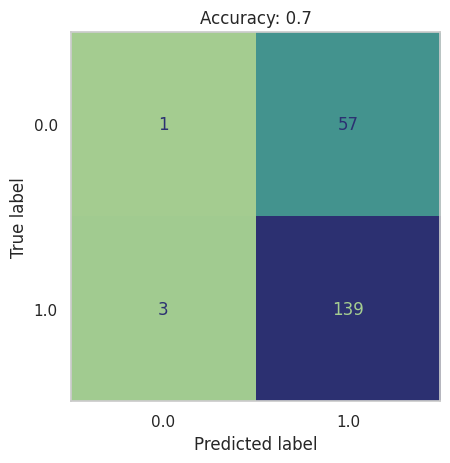

Attribute: sex

              False Negative Rate Ratio       : 0.81

              False Negative Rate Difference  : -0.00

              Disparate Impact                : 0.99

            
Attribute: age

              False Negative Rate Ratio       : 0.00

              False Negative Rate Difference  : -0.03

              Disparate Impact                : 1.03

            


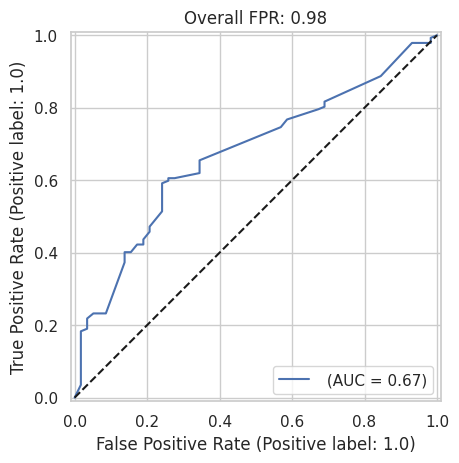

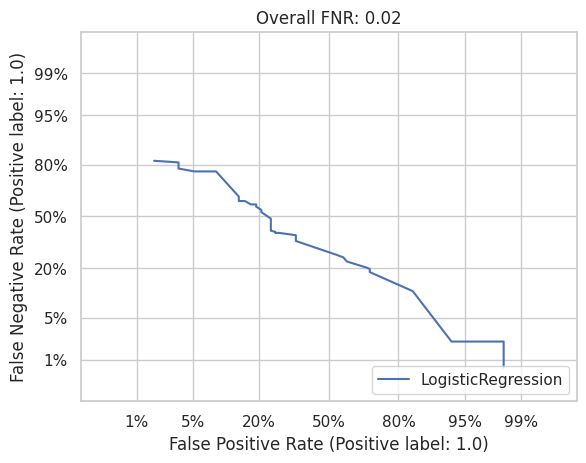

In [ ]:
evaluate(pre_model,X_test,y_test)

fairness_metrics(
    pre_model,
    test = pre_test,
    info = info
)

plot_roc(pre_model,X_test,y_test)
plot_edc(pre_model,X_test,y_test)

> **Discuss:**
1. Based on the new metrics, do you think this is a good model?
2. If yes, why? and if not, what can be improved?

> **Repeat** the same exercise using **Instance Reweighing** method for both **sex** and **age** as protected attributes. Are the results better or worse?

## In-Processing Intervention

### Exponentiated Gradient Reduction
---

Agarwal, A., Beygelzimer, A., Dudik, M., Langford, J. &amp; Wallach, H.. (2018). A Reductions Approach to Fair Classification. <i>Proceedings of the 35th International Conference on Machine Learning</i>, in <i>Proceedings of Machine Learning Research</i> 80:60-69 Available from https://proceedings.mlr.press/v80/agarwal18a.html.

This intervention trains the classifier subject to constraints which ensure **demographic-parity / equalized-odds** for all combinations of protected attributes in data. Recall that a classifier $h$ satisfies:

> **Demographic Parity** if $h \perp \!\!\! \perp A$ i.e., $P[\;h(x)=\widehat{y}\;|\;A=a\;] = P[\;h(x)=\widehat{y}\;]\;\;\forall\;a \in A $

> **Equalized Odds** if $h \perp \!\!\! \perp A\;|\;Y$ i.e., $P[\;h(x)=\widehat{y}\;|\;A=a,\;Y=y\;] = P[\;h(x)=\widehat{y}\;|\;Y=y\;]\;\;\forall\;a \in A,\;y \in Y$


          Accuracy                        : 0.71

          False Negative Rate Ratio       : 1.11

          False Negative Rate Difference  : 0.02

          Disparate Impact                : 0.94

        


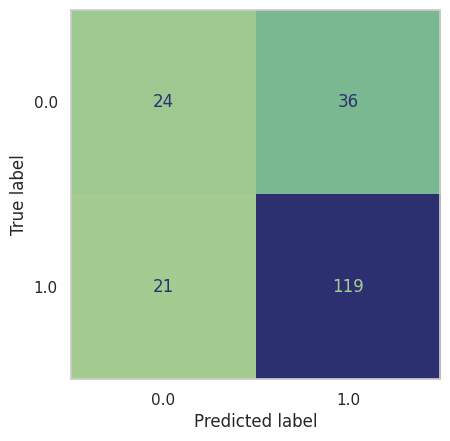

In [ ]:
# ensure same split as base
in_train, in_test = data.split([0.8], shuffle=True, seed=42)

in_model = ExponentiatedGradientReduction(
    estimator = LogisticRegression(solver='lbfgs'),
    constraints = "DemographicParity", # can also be EqualizedOdds
    drop_prot_attr = True
)
in_model = in_model.fit(in_train)
classified_test = in_model.predict(in_test)

fairness_metrics_from_predictions(
    test = in_test,
    pred = classified_test,
    unprivileged_groups = {"sex":0}, # can also be age
    label = info["label_names"]
)

> **Discuss:** Do you think this is a good model? If yes, why? and if not, what can be improved?

> **Repeat** the same exercise for **age** as the protected attribute. Are the results better or worse?

## Post-Processing Intervention

### Calibrated Odds-Equalizing
---
[Geoff Pleiss, Manish Raghavan, Felix Wu, Jon Kleinberg, and Kilian Q. Weinberger. 2017. On fairness and calibration. In Proceedings of the 31st International Conference on Neural Information Processing Systems (NeurIPS'17)](https://papers.nips.cc/paper_files/paper/2017/file/b8b9c74ac526fffbeb2d39ab038d1cd7-Paper.pdf)

> This intervention optimizes over calibrated classifier score outputs to find probabilities with which to change output labels to ensure equalized odds.

In [ ]:
# ensure same split as base
post_train, post_test = data.split([0.8], shuffle=True, seed=42)

# create validation set
post_train, post_val = post_train.split([0.75], shuffle=True, seed=42)

# create spare copies for prediction and calibration
post_val_orig = post_val.copy(deepcopy=True)
post_val_pred = post_val.copy(deepcopy=True)

post_train, info = post_train.convert_to_dataframe()
post_val, _ = post_val.convert_to_dataframe()

X_train, y_train = post_train[info["feature_names"]], post_train[info["label_names"]]
X_val, y_val = post_val[info["feature_names"]], post_val[info["label_names"]]

_model = LogisticRegression()
_model = _model.fit(X_train, y_train)
_model.classes_

array([0., 1.])


          Accuracy                        : 0.82

          False Negative Rate Ratio       : nan

          False Negative Rate Difference  : 0.00

          Disparate Impact                : 0.68

        


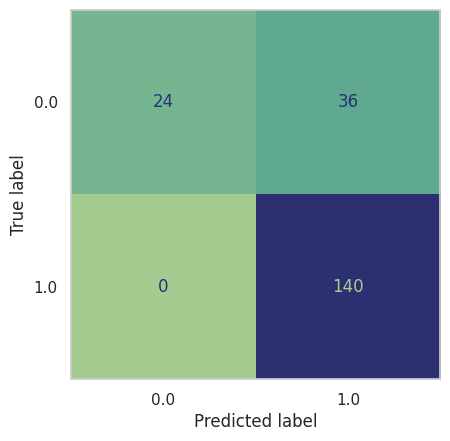

In [ ]:
post_val_pred.scores = _model.predict_proba(X_val)[:,1] # positive class
post_val_pred.labels = np.array([[l] for l in _model.predict(X_val)])

post_model = CalibratedEqOddsPostprocessing(
    unprivileged_groups = [{"sex":0}], # can also be age
    privileged_groups = [{"sex":1}], # can also be age
    cost_constraint = "fnr",

)

post_model = post_model.fit(post_val_orig, post_val_pred)

pred_test = post_model.predict(post_test)
pred_test.labels %= 2

fairness_metrics_from_predictions(
    test = post_test,
    pred = pred_test,
    unprivileged_groups = {"sex":0}, # can also be age
    label = info["label_names"]
)

> **Discuss:** Do you think this is a good model? If yes, why? and if not, what can be improved?

> **Repeat** the same exercise for **age** as the protected attribute. Are the results better or worse?